In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd
from chainconsumer import ChainConsumer
import os
import glob
import anesthetic
from scipy.stats import gaussian_kde

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
def loadMontePythonChain(directory, two_cosmo = False, params_out = None, params_out_diff = None):
    # load data
    data = np.loadtxt(directory + '/chain_NS__accepted.txt')
    # load parameter names
    filename = glob.glob(directory+'/*.paramnames')
    names = np.loadtxt(filename[0], dtype = str, delimiter='\t').T[0]
#     names = np.loadtxt(directory + '/chain.paramnames', dtype=str, delimiter='\t').T[0]
    names = np.concatenate((['weight','mloglkl'], names))
    # remove trailing spaces
    for idx, name in enumerate(names):
        if name[-1] == ' ':
            names[idx] = name[:-1]
    if two_cosmo == True:
        dataframe = pd.DataFrame(data, columns = names)
        # List of parameters that appear in the 2cosmo chain. Note: Each parameter appears twice!
        if 'delta_c' in names:
            params = ['weight','mloglkl', 'omega_cdm', 'S_8', 'omega_b', 'n_s', 'h', 'A_IA', 'c_min', 'D_z1', 'D_z2', 'D_z3', 'D_z4', 'D_z5', 'delta_c', 'Omega_m', 'sigma8']
        else:
            params = ['weight','mloglkl', 'omega_cdm', 'S_8', 'omega_b', 'n_s', 'h', 'A_IA', 'c_min', 'D_z1', 'D_z2', 'D_z3', 'D_z4', 'D_z5', 'Omega_m', 'sigma8']
#         d = np.where(dataframe['mloglkl']<10)[0]
#         dataframe = dataframe.drop(d)
#         Set up dataframes for both sets of cosmological parameters and for the difference between them
        chain1 = np.zeros((dataframe.shape[0],len(params)))
        chain2 = np.zeros((dataframe.shape[0],len(params)))
        diff = np.zeros((dataframe.shape[0],len(params)))
        for idx, param in enumerate(params):
            # two first two columns contain the weight and mlogkl.
            if idx <2:
                chain1[:,idx] = dataframe[param]
                chain2[:,idx] = dataframe[param]
                diff[:,idx] = dataframe[param]
            else:
                # Copy data of both sets of cosmological parameters to the respective dataframe and calculate the difference
                if param == 'omega_m':
                    # calculate omega_m from Omega_m and h
                    chain1[:,idx] = dataframe['Omega_m_1'] * (dataframe['Omega_m_1']/0.3)**0.5
                    chain2[:,idx] = dataframe['Omega_m_2'] * (dataframe['Omega_m_2']/0.3)**0.5
                    diff[:,idx] = dataframe['Omega_m_1'] * (dataframe['Omega_m_1']/0.3)**0.5 - dataframe['sigma8_2'] * (dataframe['Omega_m_2']/0.3)**0.5
                elif param in ['A_IA', 'c_min', 'D_z1', 'D_z2', 'D_z3', 'D_z4', 'D_z5', 'delta_c']:
                    chain1[:,idx] = dataframe[param]
                    chain2[:,idx] = dataframe[param]
                else:
                    chain1[:,idx] = dataframe[param+'_1']
                    chain2[:,idx] = dataframe[param+'_2']
                    diff[:,idx] = dataframe[param+'_1'] - dataframe[param+'_2']
        if params_out:
            chain1 = pd.DataFrame(chain1, columns = params_out)
            chain2 = pd.DataFrame(chain2, columns = params_out)
        else:
            chain1 = pd.DataFrame(chain1, columns = params)
            chain2 = pd.DataFrame(chain2, columns = params)
        if params_out_diff:
            diff = pd.DataFrame(diff, columns = params_out_diff)
        else:
            diff = pd.DataFrame(diff, columns = params)
        return(chain1,chain2,diff)
    else:
        if params_out:
            chain = pd.DataFrame(data, columns = params_out)
        else:
            chain = pd.DataFrame(data, columns = names)
        return(chain)

In [3]:
params_out = ['weight','mloglkl',r'$\omega_{\rm cdm}$', r'$S_8$', r'$\omega_{\rm b}$', r'$n_{\rm s}$', r'$h$', r'$A_{\rm IA}$', r'$c_{\rm min}$',r'$\delta z_1$', r'$\delta z_2$', r'$\delta z_3$', r'$\delta z_4$', r'$\delta z_5$', r'$\Omega_{\rm m}$', r'$\sigma_8$']
params_out_diff = ['weight','mloglkl',r'$\Delta \omega_{\rm cdm}$', r'$\Delta S_8$', r'$\Delta \omega_{\rm b}$', r'$\Delta n_{\rm s}$', '$\Delta h$', r'$A_{\rm IA}$', r'$c_{\rm min}$',r'$\delta z_1$', r'$\delta z_2$', r'$\delta z_3$', r'$\delta z_4$', r'$\delta z_5$', r'$\Delta \Omega_{\rm m}$', r'$\Delta \sigma_8$']
# List of parameters to plot:
cols_diff = [r'$\Delta \Omega_{\rm m}$', r'$\Delta S_8$', '$\Delta h$']

In [4]:
# load the chains
K1K = loadMontePythonChain('../chains/K1K_bp/', two_cosmo = True, params_out=params_out, params_out_diff=params_out_diff)
K1K_Cl = loadMontePythonChain('../chains/K1K_Cl/', two_cosmo = True, params_out=params_out, params_out_diff=params_out_diff)
K1K_ClLy = loadMontePythonChain('../chains/K1K_ClLy/', two_cosmo = True, params_out=params_out, params_out_diff=params_out_diff)
K1K_ClLyC = loadMontePythonChain('../chains/K1K_ClLyC/', two_cosmo = True, params_out=params_out, params_out_diff=params_out_diff)
# Each chain contains 3 Pandas dataframes
# 1) Cosmo 1
# 2) Cosmo 2
# 3) Difference: cosmo1 - cosmo2
# For example K1K[2] returns the chain that contains the difference between geo and growth
# I think you can pass these directly to GetDist 

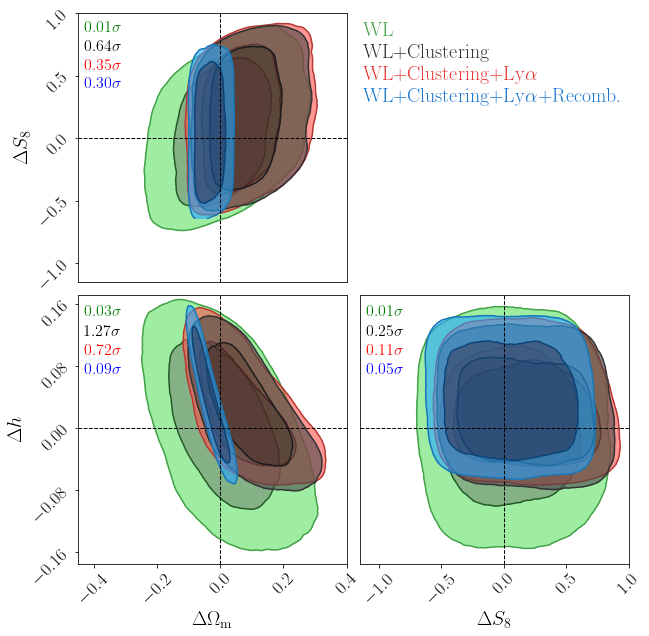

In [6]:
c = ChainConsumer()
c.add_chain(K1K[2][cols_diff], weights = K1K[2]['weight'], color='g',kde=1.5,shade=True,shade_alpha=0.6, name = 'WL', zorder = 1)
c.add_chain(K1K_Cl[2][cols_diff], weights = K1K_Cl[2]['weight'], color='k',kde=1.5,shade=True,shade_alpha=0.6, name = 'WL+Clustering', zorder = 3)
c.add_chain(K1K_ClLy[2][cols_diff], weights = K1K_ClLy[2]['weight'], color='r',kde=1.5,shade=True,shade_alpha=0.6, name = r'WL+Clustering+Ly$\alpha$', zorder = 2)
c.add_chain(K1K_ClLyC[2][cols_diff], weights = K1K_ClLyC[2]['weight'], color='b',kde=1.5,shade=True,shade_alpha=0.6, name = r'WL+Clustering+Ly$\alpha$+Recomb.', zorder = 4)
c.configure(plot_hists=False,shade_gradient=1.0,diagonal_tick_labels=True,label_font_size=20,tick_font_size=18,serif=True,legend_color_text=True,linewidths=1.5)
fig = c.plotter.plot(figsize=2.0,truth=[0,0,0], extents = {cols_diff[0]:(-0.45,0.4), cols_diff[1]:(-1.15,1)})
fig.axes[0].annotate(r'$0.01\sigma$', (-0.43,0.85), size = 16, zorder = 5, color = "g")
fig.axes[0].annotate(r'$0.64\sigma$', (-0.43,0.7), size = 16, zorder = 5, color = "k")
fig.axes[0].annotate(r'$0.35\sigma$', (-0.43,0.55), size = 16, zorder = 5, color = "r")
fig.axes[0].annotate(r'$0.30\sigma$', (-0.43,0.4), size = 16, zorder = 5, color = "b")

fig.axes[2].annotate(r'$0.03\sigma$', (-0.43,0.145), size = 16, zorder = 5, color = "g")
fig.axes[2].annotate(r'$1.27\sigma$', (-0.43,0.12), size = 16, zorder = 5, color = "k")
fig.axes[2].annotate(r'$0.72\sigma$', (-0.43,0.095), size = 16, zorder = 5, color = "r")
fig.axes[2].annotate(r'$0.09\sigma$', (-0.43,0.07), size = 16, zorder = 5, color = "b")

fig.axes[3].annotate(r'$0.01\sigma$', (-1.1,0.145), size = 16, zorder = 5, color = "g")
fig.axes[3].annotate(r'$0.25\sigma$', (-1.1,0.12), size = 16, zorder = 5, color = "k")
fig.axes[3].annotate(r'$0.11\sigma$', (-1.1,0.095), size = 16, zorder = 5, color = "r")
fig.axes[3].annotate(r'$0.05\sigma$', (-1.1,0.07), size = 16, zorder = 5, color = "b")

plt.savefig('/mnt/c/Users/Jaime/Desktop/paper_plots/diffs.pdf')
plt.show()